<a href="https://colab.research.google.com/github/Hank-Cui/KWHS2019/blob/master/Long_Score_xgboost_weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#KWHS 2019
#Long Term Score Prediction
#Analysis of Data for the past 5 years

In [0]:
############## STARTS HERE ################

In [0]:
# Mount Google Drive

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd
import numpy as np
from math import tanh
from sklearn.model_selection import train_test_split

%pip install --upgrade xgboost
import xgboost as xgb
import matplotlib.pyplot as plt

Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (0.90)


In [0]:
# Pandas Settings

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [0]:
# Read the data using Pandsa

df_useful = pd.read_csv('/gdrive/My Drive/Blair/10/KWHS2019/useful_annual(1).csv')
df_otis = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/KWHS_list.csv")

In [0]:
# Returns increased percentages of gross profit

def gross_profit(df_uf):
    d = df_uf.copy()

    gp = np.array(d['gp'], dtype=np.float32)

    annual_growth = np.diff(gp)  # Get annual difference
    growth_rate =  annual_growth / gp[:-1]  # Calculate the annual growth rate
    growth_rate = pd.DataFrame(growth_rate)  # Store the growth rates in pd
    d["gp_ma"] = growth_rate.rolling(window=3).mean()
    d["gp_ma"] = d["gp_ma"].shift(1)

    return d

In [0]:
def revenue_growth(df_uf):  # Return increase percentage
    d = df_uf.copy()
    
    revt = np.array(d['revt'], dtype=np.float32)

    annual_growth = np.diff(revt)  # Get annual difference
    growth_rate =  annual_growth / revt[:-1]  # Calculate the annual growth rate
    growth_rate = pd.DataFrame(growth_rate)  # Store the growth rates in pd
    d["revt_ma"] = growth_rate.rolling(window=3).mean()
    d["revt_ma"] = d["revt_ma"].shift(1)

    return d

In [0]:
def free_cash_flow(df_uf):  # Returns increased percentages 
    d = df_uf.copy()

    oancf = np.array(d['oancf'], dtype=np.float32)
    capx = np.array(d['capx'], dtype=np.float32)
    
    diff = oancf-capx

    annual_growth = np.diff(diff)  # Get annual difference
    growth_rate =  annual_growth / diff[:-1]  # Calculate the annual growth rate
    growth_rate = pd.DataFrame(growth_rate)  # Store the growth rates in pd
    d["cash_flow_ma"] = growth_rate.rolling(window=3).mean()
    d["cash_flow_ma"] = d["cash_flow_ma"].shift(1)

    return d

In [0]:
def ebit(df_uf):  # Finalized. Returns increased percentages
    d = df_uf.copy()
    
    ebit = np.array(d['ebit'], dtype=np.float32)

    annual_growth = np.diff(ebit)  # Get annual difference
    growth_rate =  annual_growth / ebit[:-1]  # Calculate the annual growth rate
    growth_rate = pd.DataFrame(growth_rate)  # Store the growth rates in pd
    d["ebit_ma"] = growth_rate.rolling(window=3).mean()
    d["ebit_ma"] = d["ebit_ma"].shift(1)

    return d

In [0]:
def roa(df_uf):  # Returns average yearly values
    d = df_uf.copy()

    ni = np.array(d['ni'], dtype=np.float32)
    at = np.array(d['at'], dtype=np.float32)
    lt = np.array(d['lt'], dtype=np.float32)

    roa = ni/abs(at-lt)

    growth_rate = pd.DataFrame(roa)  # Store the growth rates in pd
    d["roa_growth_rate"] = growth_rate.rolling(window=3).mean()

    return d

In [0]:
def optdr(df_uf):  # Finalized Returns increased percentages
    d = df_uf.copy()
    
    optdr = np.array(d['optdr'], dtype=np.float32)

    annual_growth = np.diff(optdr)  # Get annual difference
    growth_rate =  annual_growth / optdr[:-1]  # Calculate the annual growth rate
    growth_rate = pd.DataFrame(growth_rate)  # Store the growth rates in pd
    d["optdr_ma"] = growth_rate.rolling(window=3).mean()
    d["optdr_ma"] = d["optdr_ma"].shift(1)

    return d

In [0]:
def roe(df_uf):  # Returns average yearly values
    d = df_uf.copy()
    
    ni = np.array(d['ni'], dtype=np.float32)
    teq = np.array(d['teq'], dtype=np.float32)

    roe = ni/teq
    growth_rate = pd.DataFrame(roe)  # Store the growth rates in pd
    d["roe_ma"] = growth_rate.rolling(window=3).mean()
    d["roe_ma"] = d["roe_ma"]

    return d

In [0]:
def fundamentals(company_name):

    df_u = df_useful[df_useful['tic']==company_name]
    df_u = df_u.dropna(subset = ['gp'])  # Drop the rows that have no data
    df_u = df_u.fillna(0)
    df_u = df_u.reset_index()

    df_u = gross_profit(df_u)
    df_u = free_cash_flow(df_u)
    df_u = revenue_growth(df_u)
    df_u = ebit(df_u)
    df_u = optdr(df_u)
    df_u = roa(df_u)

    return df_u.drop(columns='tic')

In [0]:

price_df = pd.DataFrame([])

df = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/KWHS_list.csv")
stocks = df['TICKER']

for i in stocks:
    df_ = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/hist_data/"+comp_tic+".csv")
    for i in range(10):
        year = str(2009+i)
        


In [0]:
def get_annual_close(comp_tic):
    df = pd.read_csv("/gdrive/My Drive/Blair/10/KWHS2019/hist_data/"+comp_tic+".csv")
    dl = df["Date"].tolist()
    dates = []
    d_list = dl
    for i in range(1019):
        year = str(1000+i)
        if year+"-12-31" in d_list:
            dates.append(year+"-12-31")
            continue
        elif year+"-12-30" in d_list:
            dates.append(year+"-12-30")
            continue
        elif year+"-12-29" in d_list:
            dates.append(year+"-12-29")
            continue
    data = df[df['Date'].isin(dates)]
    data = np.array(data['Close'])
    return data

33

In [0]:
fundamentals("ADBE")[["gp_ma", "cash_flow_ma", "revt_ma", "ebit_ma","optdr_ma", "roa_growth_rate"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


,gp_ma,cash_flow_ma,revt_ma,ebit_ma,optdr_ma,roa_growth_rate
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,0.249985
3,3.007565,-1.861424,1.686489,4.076286,NaN,0.373025
4,0.985881,-2.091494,1.008656,0.992625,NaN,0.476891
5,0.616121,-2.558866,0.655662,0.611344,NaN,0.473524
6,0.333213,0.466647,0.401701,0.322753,NaN,0.409029
7,0.153508,0.231692,0.303129,0.138977,NaN,0.282759
8,0.127099,0.330078,0.232584,0.098608,NaN,0.226951
9,0.301003,0.202472,0.414572,0.210887,NaN,0.137424


In [0]:
from sklearn.preprocessing import MinMaxScaler

def get_Weight(comp_tic):
    fundamental = fundamentals(comp_tic)[["gp_ma", "cash_flow_ma", "revt_ma", "ebit_ma", "roa_growth_rate"]]
    size = len(fundamental)

    close_price = get_annual_close("ADBE")
    close_price = np.pad(close_price, (size-len(close_price), 0), 'constant', constant_values=(0))
    fundamental["annual_close"] = close_price

    df_close = fundamental["annual_close"]
    df_fundamentals = fundamental.drop(columns="annual_close")

    sc_y = MinMaxScaler(feature_range = (0, 1))
    y_scaled = pd.DataFrame(sc_y.fit_transform(df_close.values.reshape(-1, 1)), columns=["annual_close"])

    sc_x = MinMaxScaler(feature_range = (0, 1))
    x_scaled = pd.DataFrame(sc_x.fit_transform(df_fundamentals), columns=df_fundamentals.columns)
    
    y = y_scaled
    X = x_scaled

    X_train_FI, X_test_FI, y_train_FI, y_test_FI = train_test_split(X, y, test_size=0.33, shuffle=False)

    regressor = xgb.XGBRegressor(gamma=0.0,
                                n_estimators=1500,
                                base_score=0.6,
                                colsample_bytree=1,
                                learning_rate=0.01)

    xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                            eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                            verbose=False)

    eval_result = regressor.evals_result()
    training_rounds = range(len(eval_result['validation_0']['rmse']))

    plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
    plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.title('Training Vs Validation Error')
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(8,8))
    plt.xticks(rotation='vertical')
    plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
    plt.title('Figure 6: Feature importance of the technical indicators.')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


[03:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


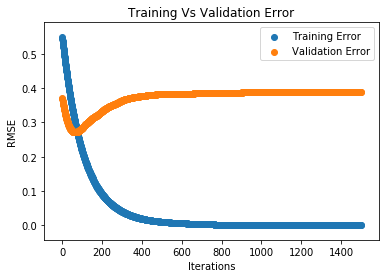

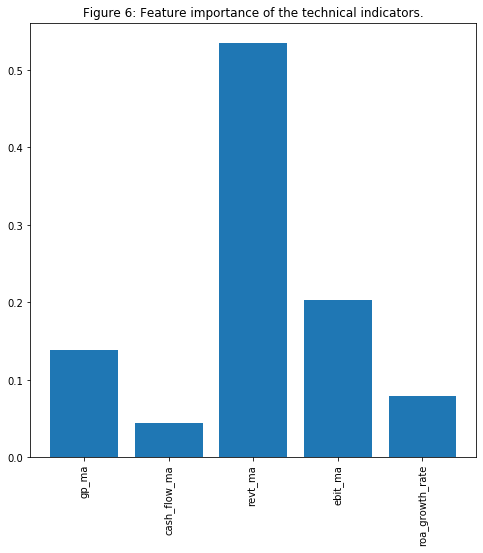

In [0]:
get_Weight("ADBE")

In [0]:
# Sum of different functions nomalized with tanh

def sum_with_tanh(Name):
    Result = 0.9 * tanh(free_cash_flow(Name)) \
            + 1 * tanh(revenue_growth(Name)) \
            + 1.7 * tanh(gross_profit(Name)) \
            + 1.2 * tanh(ebit(Name)) \
            + 0.6 * tanh(optdr(Name)) \
            + 1.2* tanh(roa(Name))
    return Result

In [0]:
df_otis.SECTOR.unique().tolist()[:-1]

['Consumer Discretionary',
 'Consumer Staples',
 'Energy',
 'Financial Services',
 'Healthcare',
 'Materials & Processing',
 'Producer Durables',
 'Technology',
 'Utilities']

In [0]:
# Store the data in Google Drive

for sector in df_otis.SECTOR.unique().tolist()[:-1]:

    sector_data = df_otis[df_otis['SECTOR'] == sector]
    data = sector_data['TICKER'].tolist()
    results_pair = {}

    for company in data:
        resultVal = sum_with_tanh(company)
        results_pair[company] = resultVal
    
    rank = sorted(results_pair.items(), key=lambda x: x[1], reverse=True)
    df_result  = pd.DataFrame(rank, columns =['Company', 'index'])
    df_result.to_csv(r"/gdrive/My Drive/Blair/10/KWHS2019/LT_Predictions/"+ sector +".csv")

In [0]:
############## ENDS HERE ##################

In [0]:
# Testing Section

compl = df_otis[df_otis["SECTOR"]=="Consumer Discretionary"]['TICKER']
compl = compl.tolist()
for comp in compl:
    assert(roe(comp) == roe1(comp))
    print(roe(comp), roe1(comp))

import time
start_time = time.time()
roe1(comp[0])
print("--- %s seconds ---" % (time.time() - start_time))
start_time2 = time.time()
roe(comp[0])
print("--- %s seconds ---" % (time.time() - start_time2))

In [0]:
useful = df[['datadate', 'tic', 'revt', 'gp', 'oancf', 'capx', 'at', 'lt', 'ebit', 'mkvalt', 'optdr', 'ni', 'epspi', 'bkvlps', 'teq']]
useful.to_csv(r"/gdrive/My Drive/Blair/10/KWHS2019/useful_annual(1).csv")